In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


In [13]:
results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class_val0.99', 'CV_results.pkl'))
results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class_val0.99', 'CV_results.pkl'))
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

## Functions

In [14]:
ab_stats_list = results_dict_noPT['ab_stats']
iso_stats_list = results_dict_noPT['iso_stats']
iso_stats_list = results_dict_mediumPT['iso_stats']
ab_stats_list = results_dict_mediumPT['ab_stats']

In [15]:
def get_average_and_std_df(results_dict):
    losses = results_dict['losses']
    accs = results_dict['accs']
    iso_accs = results_dict['iso_accs']
    sensitivities = results_dict['sensitivities']
    specificities = results_dict['specificities']
    f1_scores = results_dict['F1_scores']
    
    losses_avg = np.mean(losses)
    losses_std = np.std(losses)
    accs_avg = np.mean(accs)
    accs_std = np.std(accs)
    iso_accs_avg = np.mean(iso_accs)
    iso_accs_std = np.std(iso_accs)
    sens_avg = np.mean(sensitivities)
    sens_std = np.std(sensitivities)
    spec_avg = np.mean(specificities)
    spec_std = np.std(specificities)
    f1_avg = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    df_CV = pd.DataFrame(data={
        "metric": ["Loss", 'Accuracy', 'Isolate accuracy', 'Sensitivity', 'Specificity', 'F1'], 
        "avg": [losses_avg, accs_avg, iso_accs_avg, sens_avg, spec_avg, f1_avg], 
        "std": [losses_std, accs_std, iso_accs_std, sens_std, spec_std, f1_std]
    })
    return df_CV


def get_ab_stats_df(results_dict):
    ab_stats_list = results_dict['ab_stats']
    
    data_dict = {}
    antibiotics = ab_stats_list[0]['antibiotic'].tolist()
    data_dict.update({"antibiotic": antibiotics})
    for ab_stats in ab_stats_list:
        ab_stats['S_share'] = ab_stats['num_S'] / ab_stats['num_tot']
        ab_stats['R_share'] = ab_stats['num_R'] / ab_stats['num_tot']

    num_tot = np.array([ab_stats['num_tot'].tolist() for ab_stats in ab_stats_list])
    avg_num = np.mean(num_tot, axis=0).astype(int).tolist()
    std_num = np.std(num_tot, axis=0).tolist()
    s_shares = np.array([ab_stats['S_share'].tolist() for ab_stats in ab_stats_list])
    r_shares = np.array([ab_stats['R_share'].tolist() for ab_stats in ab_stats_list])
    s_share_median = np.median(s_shares, axis=0).tolist()
    s_share_std = np.std(s_shares, axis=0).tolist()
    r_share_median = np.median(r_shares, axis=0).tolist()
    r_share_std = np.std(r_shares, axis=0).tolist()
    data_dict.update({
        "avg_num": avg_num, "std_num":std_num,
        "S_share_median": s_share_median, "R_share_median": r_share_median,
        "S_share_std":s_share_std, "R_share_std": r_share_std
    })
    
    metrics = ['accuracy', 'sensitivity', 'specificity', "precision", 'F1']
    for metric in metrics:
        arr = np.array([ab_stats[metric] for ab_stats in ab_stats_list])
        avg = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0)
        # if np.isnan(arr).any():
        #     print("metric:", metric)
        #     print(arr)
        #     print("avg:", avg)
        #     print("std:", std)
        data_dict.update({metric+"_avg": avg.tolist(), metric+"_std": std.tolist()})

    df_ab_CV = pd.DataFrame(data=data_dict)
    return df_ab_CV

Calculate averages and std. devs.

In [24]:
df_CV_noPT = get_average_and_std_df(results_dict_noPT)
df_CV_noPT['pre-training'] = "none"
df_CV_mediumPT = get_average_and_std_df(results_dict_mediumPT)
df_CV_mediumPT['pre-training'] = "medium"

In [25]:
df_CV_noPT

,metric,avg,std,pre-training
0,Loss,0.293247,0.019130,none
1,Accuracy,0.885635,0.004245,none
2,Isolate accuracy,0.885635,0.004245,none
3,Sensitivity,0.624067,0.028870,none
4,Specificity,0.956359,0.005536,none
5,F1,0.698658,0.016283,none


## Analysis

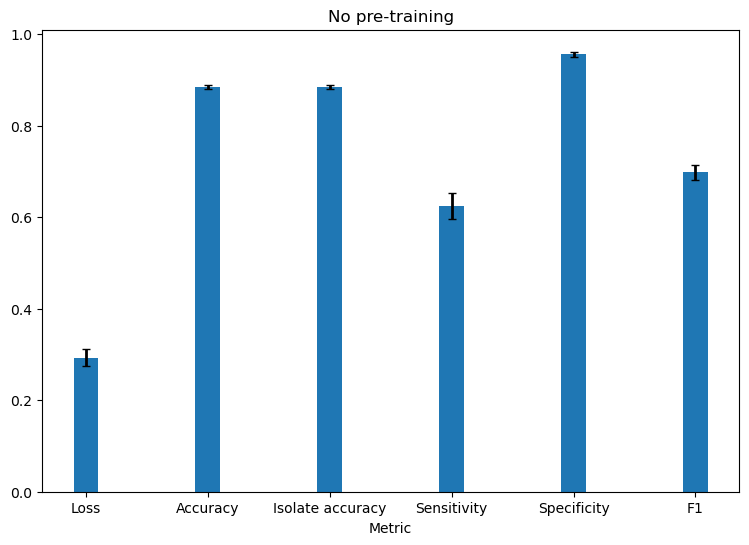

In [26]:
metric_names = ['F1', 'Sensitivity', 'Specificity', 'Accuracy', 'Isolate Accuracy']
fig, ax = plt.subplots(figsize=(9, 6))
bar_width = 0.2
ax.bar(df_CV_noPT['metric'], df_CV_noPT['avg'], width=bar_width, label="No pre-training")
ax.errorbar(df_CV_noPT['metric'], df_CV_noPT['avg'], df_CV_noPT['std'], ecolor="k", fmt="none", elinewidth=2, capsize=3)
ax.set_xlabel("Metric")
ax.set_title("No pre-training")
plt.show()

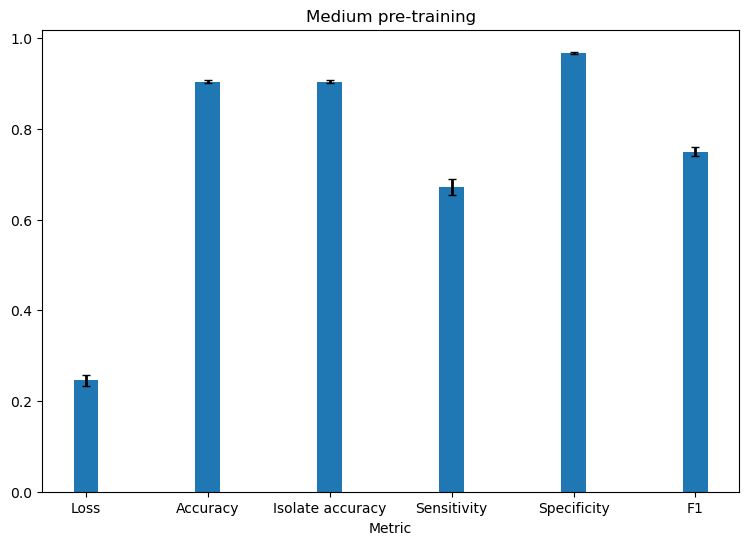

In [27]:
metric_names = ['F1', 'Sensitivity', 'Specificity', 'Accuracy', 'Isolate Accuracy']
fig, ax = plt.subplots(figsize=(9, 6))
ax.bar(df_CV_mediumPT['metric'], df_CV_mediumPT['avg'], width=0.2)
ax.errorbar(df_CV_mediumPT['metric'], df_CV_mediumPT['avg'], df_CV_mediumPT['std'], ecolor="k", fmt="none", elinewidth=2, capsize=3)
ax.set_xlabel("Metric")
ax.set_title("Medium pre-training")
plt.show()

In [28]:
df_ab_CV_noPT = get_ab_stats_df(results_dict_noPT)
df_ab_CV_noPT

C:\Users\jespe\AppData\Local\Temp\ipykernel_23992\2832584469.py:58: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(arr, axis=0)
c:\Users\jespe\miniconda3\envs\ARFusion\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,antibiotic,avg_num,std_num,S_share_median,R_share_median,S_share_std,R_share_std,accuracy_avg,accuracy_std,sensitivity_avg,sensitivity_std,specificity_avg,specificity_std,precision_avg,precision_std,F1_avg,F1_std
0,AMP,4206,34.418600,0.541587,0.458413,0.002308,0.002308,0.807742,0.012368,0.718458,0.061937,0.883117,0.031501,0.842592,0.030221,0.772725,0.028580
1,CAZ,2833,10.131140,0.731301,0.268699,0.003218,0.003218,0.862163,0.025230,0.674359,0.041950,0.931203,0.033987,0.791403,0.081725,0.725230,0.041475
2,CIP,5094,20.800000,0.816923,0.183077,0.001547,0.001547,0.904633,0.015439,0.710112,0.073796,0.948448,0.009235,0.756279,0.039652,0.730961,0.052183
3,CRO,4577,42.281911,0.809286,0.190714,0.003425,0.003425,0.889320,0.015813,0.557629,0.121760,0.967177,0.014349,0.808227,0.052235,0.648362,0.091626
4,CTX,620,8.867920,0.126853,0.873147,0.002278,0.002278,0.861644,0.035720,0.956156,0.041522,0.213409,0.219796,0.894055,0.026835,0.923267,0.020839
5,FEP,2884,14.634207,0.812653,0.187347,0.003059,0.003059,0.857795,0.025687,0.467421,0.257591,0.947407,0.046113,0.727620,0.101575,0.501911,0.221685
6,GEN,4625,21.795412,0.875109,0.124891,0.001497,0.001497,0.875993,0.001060,0.016225,0.020321,0.998463,0.002155,0.593441,0.089602,0.050549,0.036159
7,IPM,1988,31.423558,0.979859,0.020141,0.001618,0.001618,0.979065,0.001618,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN
8,LVX,2289,22.049036,0.702931,0.297069,0.001595,0.001595,0.889443,0.015655,0.796513,0.092364,0.928551,0.030397,0.832297,0.052579,0.808212,0.036828
9,MFX,50,2.966479,0.361702,0.638298,0.023605,0.023605,0.591631,0.117283,0.800000,0.400000,0.200000,0.400000,0.649114,0.025944,0.786926,0.019168


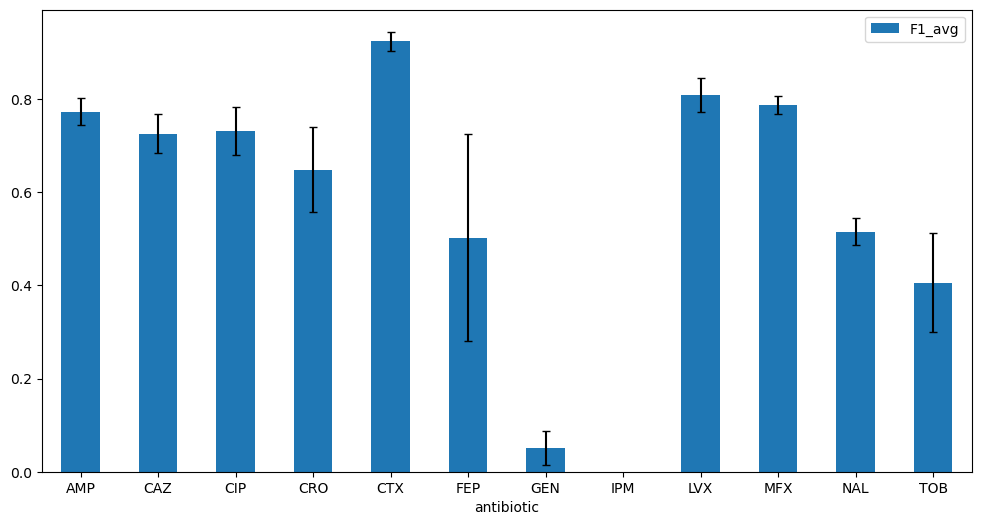

In [29]:
df_ab_CV_noPT.plot(x="antibiotic", y="F1_avg", yerr="F1_std", kind="bar", figsize=(12, 6), capsize=3, rot=0)
plt.show()

In [30]:
df_ab_CV_mediumPT = get_ab_stats_df(results_dict_mediumPT)
df_ab_CV_mediumPT

C:\Users\jespe\AppData\Local\Temp\ipykernel_23992\2832584469.py:58: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(arr, axis=0)
c:\Users\jespe\miniconda3\envs\ARFusion\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,antibiotic,avg_num,std_num,S_share_median,R_share_median,S_share_std,R_share_std,accuracy_avg,accuracy_std,sensitivity_avg,sensitivity_std,specificity_avg,specificity_std,precision_avg,precision_std,F1_avg,F1_std
0,AMP,4206,34.418600,0.541587,0.458413,0.002308,0.002308,0.829850,0.019767,0.728192,0.060439,0.915752,0.015637,0.880956,0.011509,0.795583,0.033626
1,CAZ,2833,10.131140,0.731301,0.268699,0.003218,0.003218,0.888988,0.015355,0.760619,0.023331,0.936321,0.029359,0.820454,0.060320,0.787237,0.018912
2,CIP,5094,20.800000,0.816923,0.183077,0.001547,0.001547,0.930974,0.011225,0.717163,0.049222,0.979186,0.004613,0.885439,0.027206,0.791911,0.038241
3,CRO,4577,42.281911,0.809286,0.190714,0.003425,0.003425,0.905187,0.009634,0.645365,0.082923,0.966236,0.009520,0.820677,0.028109,0.718379,0.047440
4,CTX,620,8.867920,0.126853,0.873147,0.002278,0.002278,0.895512,0.026776,0.969504,0.034217,0.387370,0.210789,0.916926,0.025556,0.941769,0.015449
5,FEP,2884,14.634207,0.812653,0.187347,0.003059,0.003059,0.871869,0.012657,0.583821,0.153664,0.937712,0.025122,0.689451,0.047037,0.619517,0.082439
6,GEN,4625,21.795412,0.875109,0.124891,0.001497,0.001497,0.891816,0.003676,0.167446,0.052747,0.994957,0.002765,0.838720,0.046396,0.274298,0.070363
7,IPM,1988,31.423558,0.979859,0.020141,0.001618,0.001618,0.979065,0.001618,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN
8,LVX,2289,22.049036,0.702931,0.297069,0.001595,0.001595,0.917927,0.020395,0.833385,0.081951,0.953581,0.018727,0.886882,0.041484,0.855832,0.041240
9,MFX,50,2.966479,0.361702,0.638298,0.023605,0.023605,0.728402,0.036157,0.897778,0.151967,0.417269,0.289114,0.763546,0.100650,0.806103,0.040648


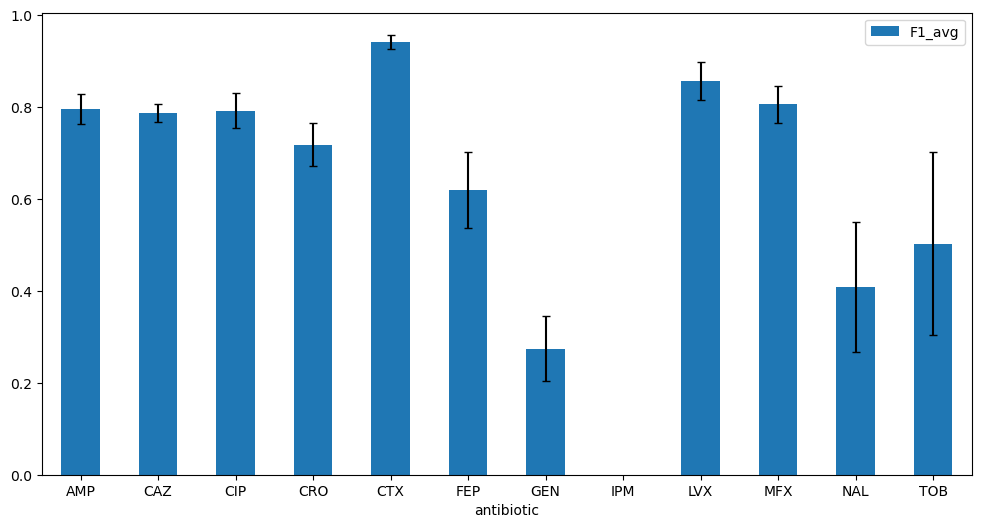

In [31]:
df_ab_CV_mediumPT.plot(x="antibiotic", y="F1_avg", yerr="F1_std", kind="bar", figsize=(12, 6), capsize=3, rot=0)
plt.show()